# Любой прогноз всегда ошибочен. Весь вопрос в том, насколько он ошибочен.

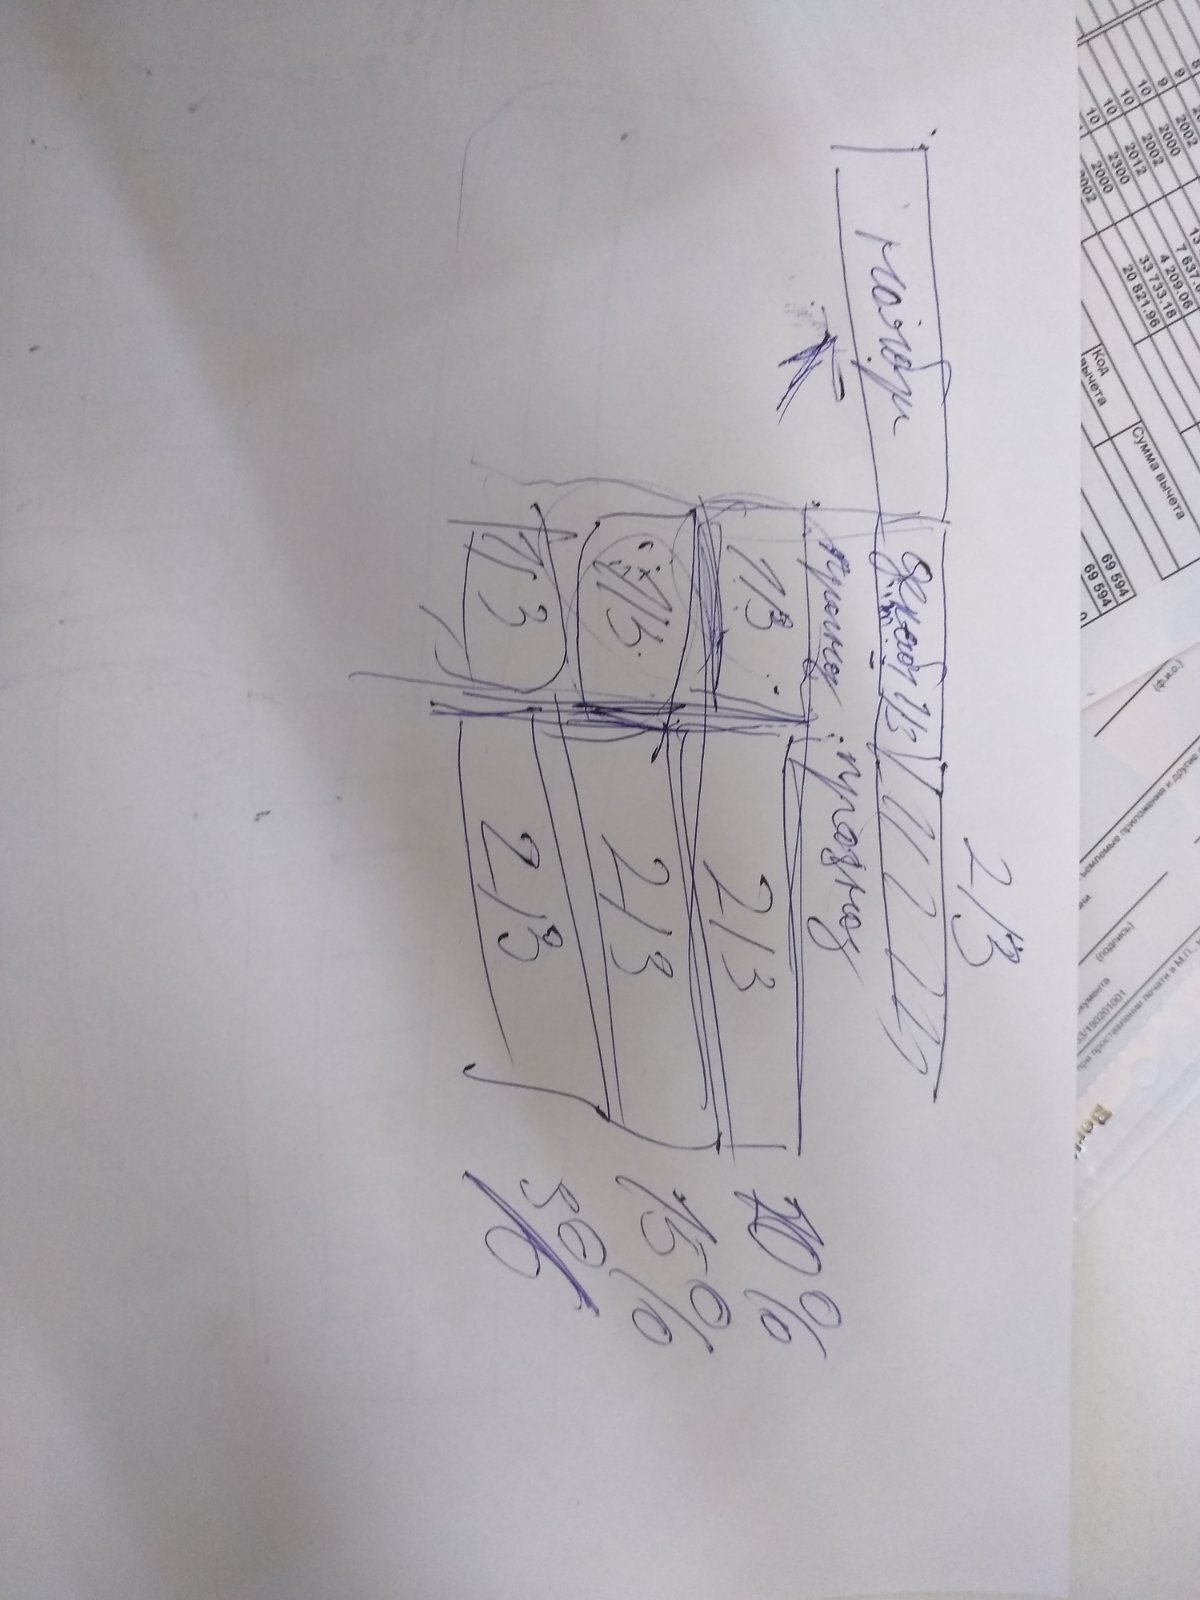

In [18]:
import pandas as pd
import numpy as np
import plotly.express as px
import datetime
from datetime import datetime, date

In [19]:
# Настройка вывода данных
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

# Прогнозирование Спроса. 
## Постановка задачи.

### Организация прогнозирования.
До того, как процесс будет автоматизирован **Необходимо**: 
- процесс описать - регламентировать, 
- описание модели прогнозирования и связанных бизнес-процессов,
- факторы - логика применений и бизнес-процесс по каждому фактору,
- согласовать регламент со всеми участниками,  
- выстроить процесс,  
- ***АВТОМАТИЗИРОВАТЬ***.

> В этом процессе строго соблюдать как минимум два правила:  
    - Использование определенной модели должно быть однозначно объяснимо с точки зрения здравого смысла. Мы можем попробовать ввести в модель продаж холодильников в Бобруйске в качестве фактора погоду в Гондурасе. И, не исключено, получим модель с меньшей ошибкой. Но до тех пор, пока мы не можем сформулировать, какова может быть причинно-следственная связь между этими явлениями, такой фактор вводить нельзя.  
    - Работа по улучшению качества прогноза (улучшению модели) стоит вполне ощутимых денег. Поэтому всегда необходимо отдавать себе отчет в том, что начиная с какого-то момента эти усилия попросту перестают окупаться. Как и в некоторых других случаях, лучше вовремя остановиться.

**Простота модели**
> Чем проще модель, тем лучше она будет воспринята менеджерами фирмы, ответственными за принятие решения, и тем выше будет их доверие к полученному прогнозу. Часто следует отдавать предпочтение не более сложному подходу к прогнозированию, предлагающему немного больше точности, а более простому, понятному руководителям компании. Когда выбранный метод получает поддержку у менеджеров, то и результаты прогнозирования активно ими используются.

### Процесс прогнозирования.
***Цикл***: 

---
1) *Подготовка данных к прогнозу (регулярный процесс)*.
> При анализе большого массива данных необходимы **индикаторы**, которые будут подсказывать, на какие позиции обратить внимание в первую очередь для проверки данных.

> Добавлять ли данные и на каком этапе о "курсах валют" или "погоды" с привязкой к временным рядам, в сырые данные, дабы улучшить будующую модель? Ответ на данный вопрос можно получить из процесса прогнозирования(описаного ниже).  

***! атуально добавлять некоторые данные - внешние факторы, в сырые данные, после формирования модели прогнозирования на основании внутренних факторов***

___
- **Индикатор №1**. ***Коэффициент вариации***. (подходит для выделения событий за последний период).  
    Расчет коэффициента осуществляется по формуле:
    $CV = (\sigma / k) * 100$

    $\sigma$ - среднеквадратическое отклонение случайной величины.  
    $k$ - ожидаемое (среднее) значение случайной величины.
    
    В статистике принято, что:
    если коэффициент вариации меньше 10%, то степень рассеивания данных считается незначительной;
    если от 10% до 20% - средней;
    больше 20% и меньше или равно 33% - значительной.
    Если значение коэффициента вариации не превышает 33%, то совокупность считается однородной, а если больше 33%, то – неоднородной.

    Одно из важных применений коэффициента вариации - оценка инвестиционных рисков. Действительно, чем выше вариативность доходности некоторого инвестиционного инструмента, тем выше связанные с ним риски. Коэффициент вариации является относительной мерой риска на единицу доходности, поэтому позволяет сопоставлять риск и доходность двух и более активов, которые могут существенно отличаться.

    Другими словами, коэффициент вариации увязывает среднеквадратическое отклонение с ожидаемой доходностью актива, что дает возможность оценить соотношение «риск/доходность» в относительном выражении и позволяет обеспечить сопоставимость полученных результатов.
    
    Минимизировать коэф-т вариации с помощью:  
    - **группировки**,  
    - **уплотнения**(сворачивание данных(отдельные товары в товарные группы ...)),  
    - **очистки дефицита**,  
    - **подмены**,  
    - **восстановления**,  
    - **очистки факторов**  
    
*Пример*:  
        сделать из массива выборку за последние 4 месяца и проанализировать вариативность последних 4-х месяцев. Если значение коэффициента вариации больше 30%, то стоит изучить конкретный временной ряд и определить **факторы**, повлиявшие на отклонение.  
    

    
___
- **Индикатор №2**. ***Диаграмма размаха ("ящик с усами")***. (подходит для поиска, внутри конкретного временного ряда, момента времени в котором произошел выброс. Также подходит для поиска факторов создающих выбросы во временных рядах). 

<img src="box-and-whiskers_diagram.png" style="widht:400px; height:400px"/>

**Виды наблюдений**, которые можно сделать на основе ящика с усами:  
- Каковы ключевые значения, например: средний показатель, медиана 25го перцентиля и так далее.  
- Существуют ли выбросы и каковы их значения.  
- Симметричны ли данные.  
- Насколько плотно сгруппированы данные.  
- Смещены ли данные и, если да, то в каком направлении.  

> Выбросы - это части данных, что попали либо выше первого квартиля либо ниже 4-го квартиля на полтора межквартильных размаха. Другими словами, выбросы - такая часть данных, что не попадает в границы доверительных интервалов.

> Доверительный интервал определяется от медианы(всей выборки временного ряда, отсортированного от min к max)

> Межквартильный размах - разница между верхней и нижней квартилью.

___
- **Индикатор №3**. ***Анализ корреляции***. (Определение оптимального набора данных для прогноза).

    > Обработчик на основании вычисляемых коэффициентов корреляции выявляет взаимосвязь между рядами данных входного набора. Применяется для оценки предполагаемой зависимости факторов.

    Позволяет определить, процент влияния определенных факторов на процесс в целом.  

    **Например**: Определить влияние акций на продаваемость групп товаров.

___
- **Индикатор №4**. ***Многомерная регрессия***. (Полезна поскольку отдельные одномерные модели игнорируют корреляции).
    > Суть регрессионного анализа: построение математической модели и определение ее статистической надежности.
    Вид множественной линейной модели регрессионного анализа: $Y = b0 + b1xi1 + ... + bjxij + ... + bkxik + ei$  
    *где $e_i$ - случайные ошибки наблюдения, независимые между собой, имеют нулевую среднюю и дисперсию $s$.*
        
    **Назначение множественной регрессии**: анализ связи между несколькими независимыми переменными и зависимой переменной. Cмысл параметров множественной регрессии, в том
    что коэффициент множественной регрессии $b_j$ показывает, на какую величину в среднем изменится результативный признак $Y$, если переменную $X_j$ увеличить на единицу измерения, т. е. является нормативным коэффициентом.

    **Действия**
    1.) Выделяются события в отдельные столбцы (Пример: Берется выборка типа: Временной ряд + Акция).
    2.) 1 - есть событие. 0 - нет события.
    3.) Оценивается влияние событий.
    4.) Очищаем данные от событий.
    5.) Строим прогноз на восстановленных данных.
    6.) Корректируется прогноз событиями.

---
- Сбор данных (продажи, факторы, события которые повлияли на результат продаж).

---
- Учет факторов (анализ факторов и событий, что повлияли на прогноз).  
    По каждому фактору описывается механизм его приминения:  
    Внутренние факторы:
    - Прирост объема продаж.  
    - Объем продаж.  
    - Прогноз объема продаж.  
    
    Внешний фактор:  
    - Корректировка коэффициентом регрессии - многофакторная модель.

<img src="Примеры_факторов.png" style="widht:800px; height:400px"/>

---
- Создание групп прогнозирования (анализ продаж по продуктовой матрице, выбор групп прогнозирования).

---
- Очистка данных от выбросов - аномальных значений.

**Популярное**

*Один из самых интересных методов* сглаживания - восстановления данных (исправления места во временном ряде где зафиксированы выбросы), это взять для анализа временной ряд до того как случился выброс и составить прогноз для того самого участка где выброс был зафиксирован, тем самым заменив новым значением место выброса.

<img src="Очистка_данных_прогнозом.png" style="widht:800px; height:200px"/>


*Второй способ* - это восстановление очень короткого промежутка (неполного месяца в полный). 

**Пример**:  
Было 30 продаж одного товара, за 16 дней из 31. Соответственно 30/16х31 ~= 58 продаж ожидается.

*Третий способ* - Отказ от части данных. Если выбранный временной ряд не коррелирует с другими.

**Пример**:  
2016 год не коррелирует с 2018 - то просто отказываемся от него, без попыток восстановления, потому что, скорее всего в последнее время были внесены координальные перемены в процесс ведения деятельности и этот процесс стал сильно отличаться от выбранного временного ряда.

---
2) Выбор модели и расчет прогноза.  

    Анализ временных рядов.
    
___
    Подбор модели.

___
    Тестирование модели.

___
    Расчет прогноза.

---
3) Корректировка прогноза факторами. 

> **ВАЖНО** Каждый фактор - это маленькая модель прогнозирования и от точности прогноза по каждому фактору зависит в целом итоговая точность прогноза по компании.

> Прогноз + доп.факторы. По каждому фактору описывается логика его применения к прогнозу.
    
<img src="Учет_доп_факторов_в_прогнозе.png"/>
---

4) Оценка точности прогноза.  
> Так как инструментов анализа много, то все зависит от того, в какой момент времени этапа прогноза какой инструмент использовать.

## Процесс прогнозирования.

<img src="Процесс_прогнозирования.png"/>

- Например можно использовать факторы на этапе "сырых данных", потом к "подготовленным данным" применить другие факторы.
- Определить группы прогнозирования (собрать статистику в группы).
- Подобрать модель прогнозирования.
- Рассчитать прогноз.
- На основании ошибки, которая осталась от прогноза, определить влияние внешних факторов на эту ошибку. Применить внешние факторы к прогнозу.
- Расчитать прогноз с учетом внешних факторов и распределить это все на позиции ниже(анализируемые в группах позиции).
- Скорректировать прогноз внутренними факторами.

## Подготовка формул  прогнозной модели.

### Наивные методы прогнозирования.

#### ***Простое среднее***   

>В простом случае, когда измеренные значения колеблются вокруг некоторого уровня, очевидным является оценка среднего значения и предположение о том, что и впредь реальные продажи будут колебаться вокруг этого значения.

$
Y(t)=C+\varepsilon(t)
$

$
C = \frac{1}{N}\sum\limits_{1}^N X
$

#### ***Скользящее среднее***

>Одной из модификаций модели среднего, учитывающей это явление, является отбрасывание наиболее старых данных и использование для вычисления среднего лишь нескольких k последних точек.

$C = \frac{1}{N}\sum\limits_{N-k}^N X$

#### ***Взвешенное скользящее среднее***

> Следующим шагом в модификации модели является предположение о том, что более поздние значения ряда более адекватно отражают ситуацию. Тогда каждому значению присваивается вес, тем больший, чем более свежее значение добавляется.

$C=\frac{\sum\limits_{N-k}^N a_iX_i}{\sum\limits_{N-k}^N a_i}$

> Для удобства можно сразу выбрать коэффициенты таким образом, чтобы сумма их составляла единицу, тогда не придется делить. Будем говорить, что такие коэффициенты отнормированы на единицу.

## Подготовка данных.
### Сбор сырых(исходных) данных.

In [20]:
df_f = pd.read_excel("d.xlsx", sheet_name='Лист1')
df_f

,Территориальная иерархия ДНС,Абк в ТЦ Калина ФТ,Unnamed: 2,Unnamed: 3,Unnamed: 4,...,Unnamed: 3385,Unnamed: 3386,Unnamed: 3387,Unnamed: 3388,Unnamed: 3389
0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,Сумма выручки,Названия столбцов,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,Названия строк,2011-08-16,2011-09-05,2011-09-06,2011-09-07,...,2020-12-16,2020-12-17,2020-12-18,2020-12-19,Общий итог
3,01. Ноутбуки,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,01. Нетбуки,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2442615
...,...,...,...,...,...,...,...,...,...,...,...
267,Цепные пилы,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,358979
268,Шуруповерты,NaN,NaN,NaN,NaN,...,NaN,2250,NaN,7999,1.45469e+06
269,Отсутствует,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
270,Отсутствует,0,99012,107181,271470,...,1703837,1376023,2155250,2.57066e+06,1.54422e+09


### Подготовка данных

In [21]:
# Удаление лишних столбцов и колонок
df_clear = df_f.drop(index=[0, 1, 269, 270, 271], columns='Unnamed: 3389').reset_index().drop(columns='index')

In [22]:
# Транспонирование таблицы из строк в столбцы
df_test = df_clear.transpose().reset_index(drop=True)
df_test

,0,1,2,3,4,...,262,263,264,265,266
0,Названия строк,01. Ноутбуки,01. Нетбуки,02. Ноутбуки,03. Аксессуары для ноутбуков,...,Перфораторы,Сварочные Аппараты,Тепловые пушки,Цепные пилы,Шуруповерты
1,2011-08-16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,2011-09-05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
3,2011-09-06,NaN,NaN,65797,NaN,...,NaN,NaN,NaN,NaN,NaN
4,2011-09-07,NaN,NaN,86395,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3384,2020-12-15,NaN,NaN,362697,-2499,...,NaN,NaN,NaN,NaN,NaN
3385,2020-12-16,NaN,NaN,380990,NaN,...,14158,NaN,NaN,NaN,NaN
3386,2020-12-17,NaN,NaN,134997,2150,...,NaN,NaN,NaN,NaN,2250
3387,2020-12-18,NaN,NaN,181446,NaN,...,NaN,NaN,NaN,NaN,NaN


In [23]:
# Применение к строке из списка роли имен колонок.
df_test.columns = df_test.iloc[0]

fragment_01 = df_test.reindex(df_test.index.drop(1)).drop(index=0)
fragment_01 = fragment_01.rename(columns={"Названия строк": 'Дата'}).reset_index(drop=True)
fragment_01.columns.name = 'ID'

In [24]:
# Получить все имена колонок.
fragment_01.columns.tolist()[:5]

['Дата',
 '01. Ноутбуки',
 '01. Нетбуки',
 '02. Ноутбуки',
 '03. Аксессуары для ноутбуков']

In [25]:
# Удаление ненужных колонок
fragment_01 = fragment_01.drop(columns=[
    '01. Ноутбуки',
    '02. Компьютеры',
    'EOL/Не используется',
    '03. Комплектующие',
    '04. Мониторы',
    '05. Сотовые, планшеты и электронные книги',
    '06. Камеры цифровые',
    '07. Карманные гаджеты',
    '08. ТВ и медиа',
    '09. Акустика',
    '10. Кабельная продукция',
    '11. Печатающая офисная техника/Оргтехника',
    '13. Источники бесперебойного питания',
    '14. Мелочи и аксессуары',
    '16. Чехлы и сумки',
    '17. Расходники и накопители информации',
    '18. Бытовая техника',
    '19. Автоэлектроника',
    '20. Интертеймент',
    '21. Сетевое Оборудование',
    '22. Источники питания',
    '23. Сумки',
    '26. Инструменты'
])

In [26]:
# Общее кол-во пропущенных элементов
# fragment_01.isnull().sum().sum()

In [39]:
# Приведение типа "datetime64" к колонке.
fragment_01['Дата'] = pd.to_datetime(fragment_01['Дата'], format='%Y-%m-%d')
fragment_01 = fragment_01.fillna(0)

In [37]:
fragment_01 # Как же бесит то, что без регулярных выражений эти (01. Нетбуки	02. Ноутбуки...) не убрать. Данные полученные из Excel(((.

ID,Дата,01. Нетбуки,02. Ноутбуки,03. Аксессуары для ноутбуков,ГСБ,...,Перфораторы,Сварочные Аппараты,Тепловые пушки,Цепные пилы,Шуруповерты
0,2011-09-05,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
1,2011-09-06,NaN,65797,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
2,2011-09-07,NaN,86395,NaN,6650,...,NaN,NaN,NaN,NaN,NaN
3,2011-09-08,27954,48279,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
4,2011-09-09,NaN,56004,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
3382,2020-12-15,NaN,362697,-2499,51998,...,NaN,NaN,NaN,NaN,NaN
3383,2020-12-16,NaN,380990,NaN,NaN,...,14158,NaN,NaN,NaN,NaN
3384,2020-12-17,NaN,134997,2150,45048,...,NaN,NaN,NaN,NaN,2250
3385,2020-12-18,NaN,181446,NaN,55198,...,NaN,NaN,NaN,NaN,NaN


In [41]:
fragment_01

ID,Дата,01. Нетбуки,02. Ноутбуки,03. Аксессуары для ноутбуков,ГСБ,...,Перфораторы,Сварочные Аппараты,Тепловые пушки,Цепные пилы,Шуруповерты
0,2011-09-05,0.0,0.0,0.0,0.0,...,0,0,0,0,0.0
1,2011-09-06,0.0,65797.0,0.0,0.0,...,0,0,0,0,0.0
2,2011-09-07,0.0,86395.0,0.0,6650.0,...,0,0,0,0,0.0
3,2011-09-08,27954.0,48279.0,0.0,0.0,...,0,0,0,0,0.0
4,2011-09-09,0.0,56004.0,0.0,0.0,...,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3382,2020-12-15,0.0,362697.0,-2499.0,51998.0,...,0,0,0,0,0.0
3383,2020-12-16,0.0,380990.0,0.0,0.0,...,14158,0,0,0,0.0
3384,2020-12-17,0.0,134997.0,2150.0,45048.0,...,0,0,0,0,2250.0
3385,2020-12-18,0.0,181446.0,0.0,55198.0,...,0,0,0,0,0.0


In [45]:
# Итак, у нас в распоряжении есть данные о прошлом спросе.
# Пусть это выглядит так:
fragment_01[['Дата', '02. Ноутбуки']]

ID,Дата,02. Ноутбуки
0,2011-09-05,0.0
1,2011-09-06,65797.0
2,2011-09-07,86395.0
3,2011-09-08,48279.0
4,2011-09-09,56004.0
...,...,...
3382,2020-12-15,362697.0
3383,2020-12-16,380990.0
3384,2020-12-17,134997.0
3385,2020-12-18,181446.0
